# Geospatial Data with Plotly

## import package

In [1]:
import pandas as pd
from sqlalchemy import create_engine
from dotenv import dotenv_values
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo  # Import and Set notebook mode to work in offline
pyo.init_notebook_mode()
from geopy.geocoders import Nominatim
import plotly.figure_factory as ff

## sqlalchemy logins

In [2]:
# retrieve values from .env file
config = dotenv_values('../notebook/02-sql_with_python/.env')

In [3]:
# define variables for the login
username = config['USER']
password = config['PASS']
host = config['HOST']
port = config['PORT']

In [4]:
# create postgresql connection string
url = f'postgresql://{username}:{password}@{host}:{port}/climate'

In [5]:
# create engine using connection string
engine = create_engine(url, echo = False)

## Data wrangling

In [6]:
# run sql to JOIN
with engine.begin() as conn:
    result = conn.execute("""
        SELECT *
        FROM 
            (SELECT *
            FROM yearly_mean_temperature
            LEFT JOIN stations
            USING (staid)) AS temp_data
        LEFT JOIN countries
        ON temp_data.cn = countries.alpha2
        ;   
    """)
    data = result.all()

In [7]:
# transform to df
df_join = pd.DataFrame(data)
df_join

# update datatypes, format
df_join['year'] = df_join['year'].astype('Int64') # change year datatype from float to int
df_join['yearly_temp'] = df_join['yearly_temp'].astype(float)*0.1 # change yearly temp datatype from object to float
df_join

staid  yearly_temp  year         staname  cn        lat         lon  \
0           1     0.000000  1860         VAEXJOE  SE  +56:52:00  +014:48:00   
1           1     0.000000  1862         VAEXJOE  SE  +56:52:00  +014:48:00   
2           1     0.000000  1864         VAEXJOE  SE  +56:52:00  +014:48:00   
3           1     0.000000  1865         VAEXJOE  SE  +56:52:00  +014:48:00   
4           1     0.000000  1866         VAEXJOE  SE  +56:52:00  +014:48:00   
...       ...          ...   ...             ...  ..        ...         ...   
332004  25156     8.580548  2021          KROSNO  PL  +49:42:24  +021:46:09   
332005  25156    10.816484  2022          KROSNO  PL  +49:42:24  +021:46:09   
332006  25157     7.371495  2022  YLJA KRAFTVERK  NO  +61:11:49  +008:22:50   
332007  25159    10.138053  2022       FARKOLLEN  NO  +69:48:15  +028:59:36   
332008  25163     9.258772  2022        KORGASEN  NO  +69:56:11  +028:22:37   

        hght                             coordinates                 latitude  \
0        166                (56.86666666666667,14.8)  56.86666666666666666667   
1        166                (56.86666666666667,14.8)  56.86666666666666666667   
2        166                (56.86666666666667,14.8)  56.86666666666666666667   
3        166                (56.86666666666667,14.8)  56.86666666666666666667   
4        166                (56.86666666666667,14.8)  56.86666666666666666667   
...      ...                                     ...                      ...   
332004   326  (49.70666666666666,21.769166666666667)  49.70666666666666666667   
332005   326  (49.70666666666666,21.769166666666667)  49.70666666666666666667   
332006   517   (61.19694444444445,8.380555555555556)  61.19694444444444444444   
332007   321  (69.80416666666666,28.993333333333332)  69.80416666666666666667   
332008   418  (69.93638888888889,28.376944444444444)  69.93638888888888888889   

                      longitude alpha2    name alpha3  code   lat   lon  
0       14.80000000000000000000     SE  Sweden    SWE   752  62.0  15.0  
1       14.80000000000000000000     SE  Sweden    SWE   752  62.0  15.0  
2       14.80000000000000000000     SE  Sweden    SWE   752  62.0  15.0  
3       14.80000000000000000000     SE  Sweden    SWE   752  62.0  15.0  
4       14.80000000000000000000     SE  Sweden    SWE   752  62.0  15.0  
...                         ...    ...     ...    ...   ...   ...   ...  
332004  21.76916666666666666667     PL  Poland    POL   616  52.0  20.0  
332005  21.76916666666666666667     PL  Poland    POL   616  52.0  20.0  
332006   8.38055555555555555556     NO  Norway    NOR   578  62.0  10.0  
332007  28.99333333333333333333     NO  Norway    NOR   578  62.0  10.0  
332008  28.37694444444444444445     NO  Norway    NOR   578  62.0  10.0  

[332009 rows x 17 columns]

---
### Create animated choropleth map of the temperature of countries over time.

Tips: Referring to the derived table yearly_mean_temperature made in the advanced SQL milestone import the yearly average temp per country, alpha codes and the year from database into a pandas dataframe. A complex join will be neccessary. Use the choropleth plot function from plotly with its animation_frame parameter in order to animate the plot.

In [8]:
df_1 = df_join.groupby(['year','alpha2','alpha3','name'])['yearly_temp'].mean().reset_index().sort_values(by = ['year','name'], ascending = True)
df_1.head()

year alpha2 alpha3    name  yearly_temp
0  1756     SE    SWE  Sweden          0.0
1  1757     SE    SWE  Sweden          0.0
2  1759     SE    SWE  Sweden          0.0
3  1760     SE    SWE  Sweden          0.0
4  1762     SE    SWE  Sweden          0.0

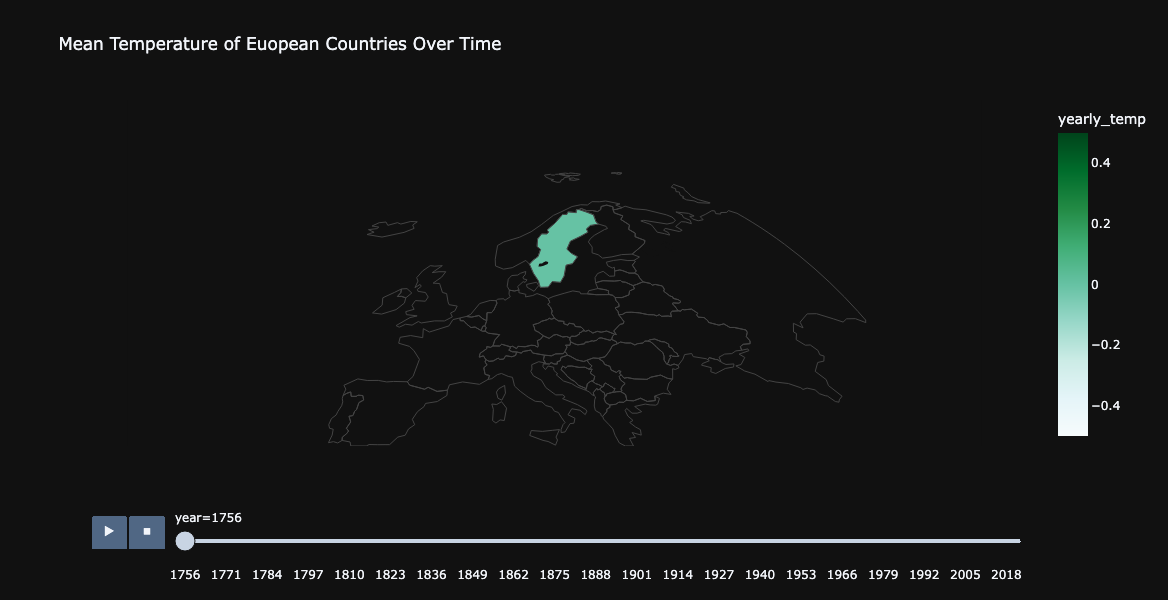

In [9]:
fig = px.choropleth(
    data_frame=df_1,
    locations="alpha3", projection='orthographic',
    color="yearly_temp", 
    hover_name="name", # column to add to hover information
    color_continuous_scale= 'Bugn',
    animation_frame = 'year',
    animation_group = 'name',
    height = 600,
    scope='europe',
    template = 'plotly_dark',
    title = 'Mean Temperature of Euopean Countries Over Time'
)

fig.show()
fig.write_html('time_series_meantemp.html')

### Create scattermap of all the weather stations in the data.

Tips: Using an inner join import a dataframe into pandas with the station name, alpha country code, and coordinates. Use the `scatter_geo` function from plotlyto visualize the locations of the each weather station. https://plotly.com/python-api-reference/generated/plotly.express.scatter_geo.html

In [10]:
df_2 = df_join[['year','staname', 'alpha3', 'latitude', 'longitude']].drop_duplicates(subset = 'staname').sort_values(by = 'year', ascending = True).reset_index(drop = True)
df_2.head()

year            staname alpha3                 latitude  \
0  1756             VARTAN    SWE  59.35000000000000000000   
1  1756        STOCKHOLM_A    SWE  59.34000000000000000000   
2  1756          STOCKHOLM    SWE  59.35000000000000000000   
3  1763              MILAN    ITA  45.47166666666666666667   
4  1775  PRAHA-KLEMENTINUM    CZE  50.08638888888888888889   

                 longitude  
0  18.10000000000000000000  
1  18.05972222222222222222  
2  18.05000000000000000000  
3   9.18916666666666666666  
4  14.41638888888888888889

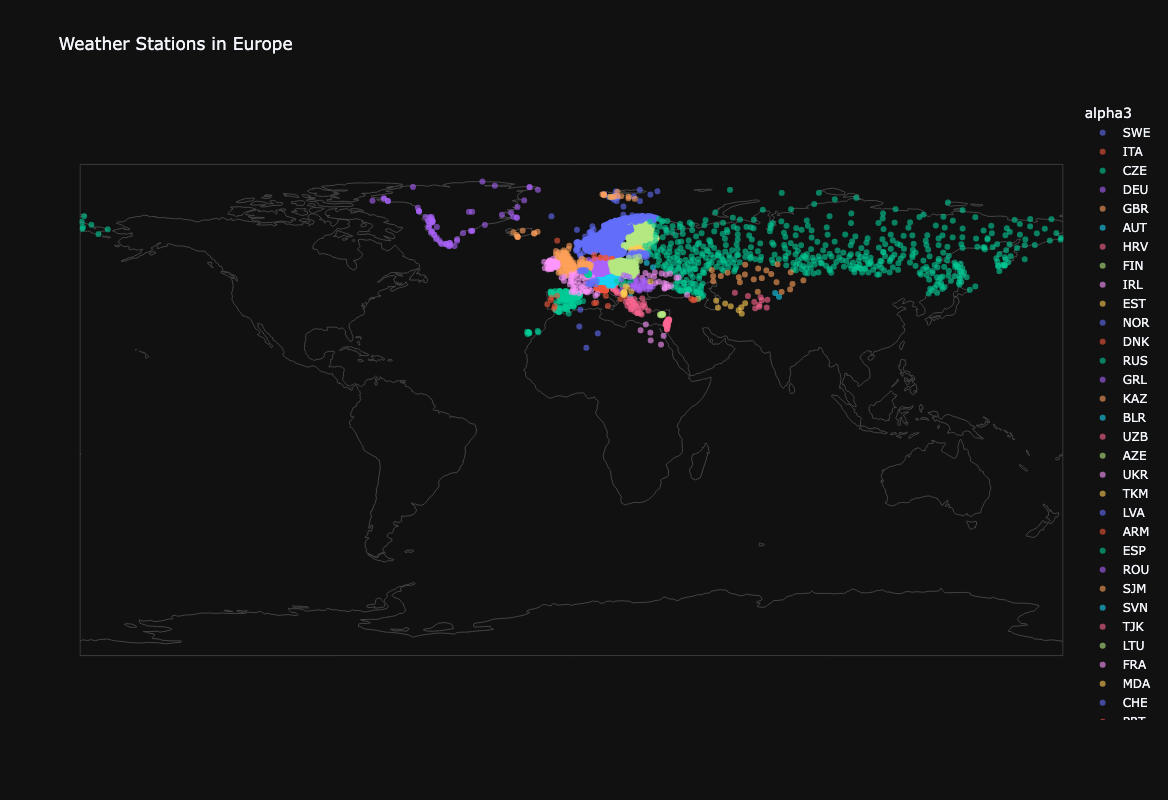

In [11]:
fig = px.scatter_geo(df_2, 
                        lat="latitude", 
                        lon="longitude", 
                        # projection = 'equirectangular',
                        hover_name="staname", 
                        color_continuous_scale= 'Bugn',
                        color = 'alpha3',
                        height = 800,
                        # width = 800,
                        template = 'plotly_dark',
                        # animation_frame = 'year',
                        opacity=0.6,
                        title = 'Weather Stations in Europe'
                        )
fig.show()
fig.write_html('weather_stations_map.html')

---
## Advanced

### Create hexbin map of Germany and the average temperature of each hexagone being the avgerage temperature of that region in a particular year.

Tips: Import the data using a join in order to have a dataframe with the station id, avgerage temperature and coordinates. Explore the `plolty.figure_factory` module and the `create_hexbin_mapbox` function and all it has to offer.

In [12]:
# groupby and transform datatypes
df_3 = df_join.groupby(['staid', 'year', 'staname', 'alpha3', 'latitude', 'longitude'])[['yearly_temp']].mean().sort_values(by = ['staid','year'], ascending = True).reset_index(drop = False)
df_3['latitude'] = df_3['latitude'].astype(float)
df_3['longitude'] = df_3['longitude'].astype(float)

# mask only Germany
df_3 = df_3[df_3['alpha3'] == 'DEU']
df_3.head()

staid  year  staname alpha3   latitude  longitude  yearly_temp
3827     40  1949  BAMBERG    DEU  49.875278  10.921667     9.856164
3828     40  1950  BAMBERG    DEU  49.875278  10.921667     9.353973
3829     40  1951  BAMBERG    DEU  49.875278  10.921667     9.636986
3830     40  1952  BAMBERG    DEU  49.875278  10.921667     8.407650
3831     40  1953  BAMBERG    DEU  49.875278  10.921667     9.088767

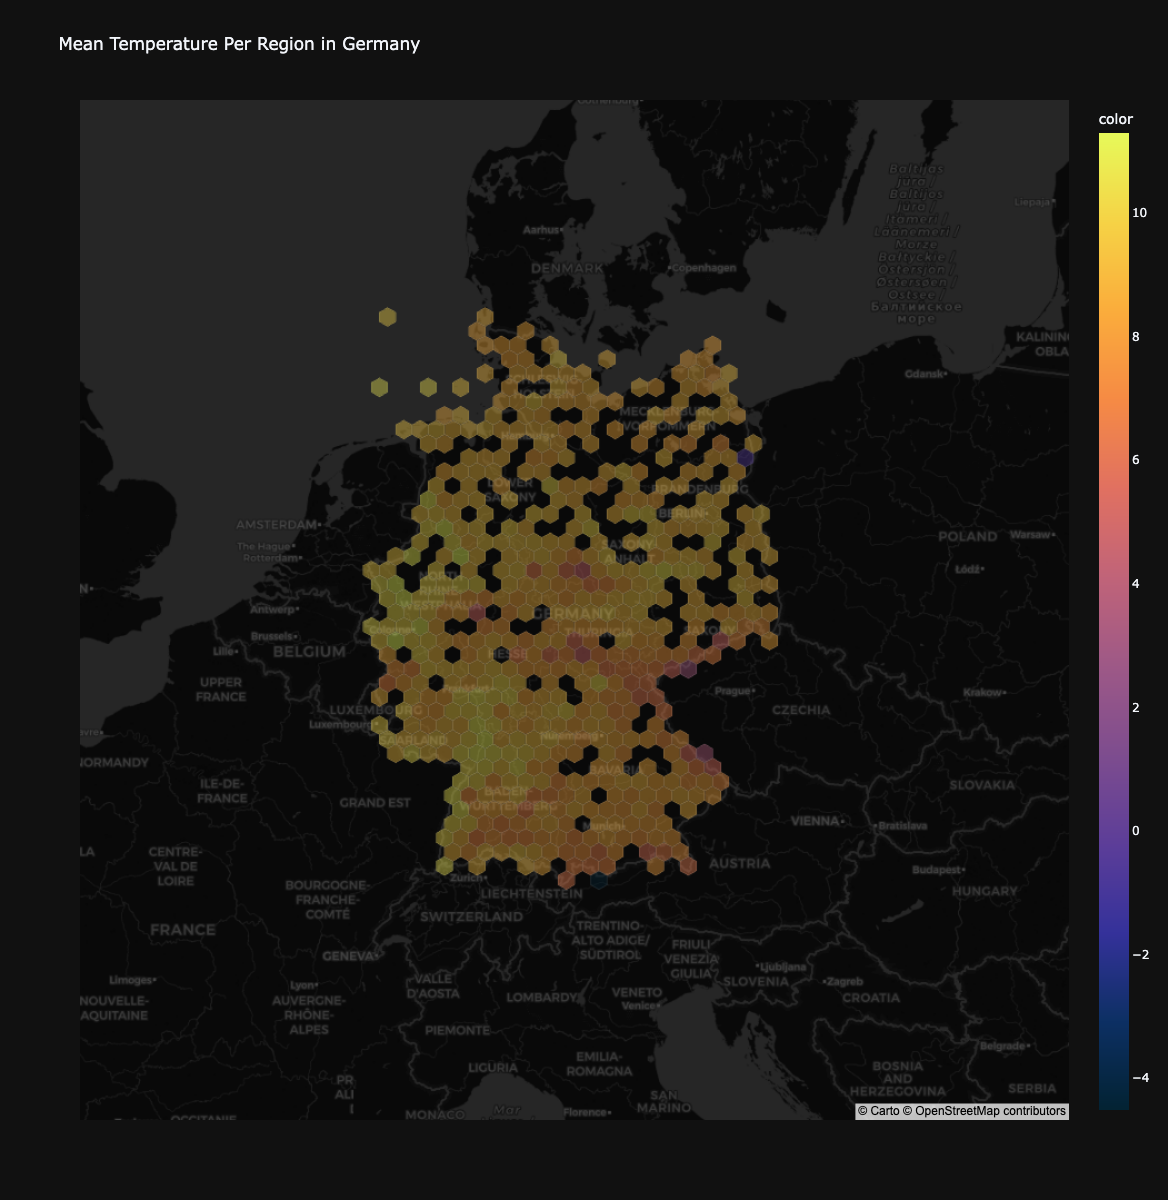

In [13]:
#plotting
import plotly.figure_factory as ff

fig = ff.create_hexbin_mapbox(df_3,
                            lat = 'latitude',
                            lon = 'longitude',
                            nx_hexagon = 25,
                            labels={'hover_name': 'staname'},
                            color = 'yearly_temp',
                            color_continuous_scale= 'thermal',
                            # animation_frame = 'year',
                            height = 600,
                            # width = 1000,
                            zoom = 5,
                            mapbox_style = 'carto-darkmatter',
                            template = 'plotly_dark',
                            opacity=0.4,
                            title = 'Mean Temperature Per Region in Germany'
                           )
fig.show()
fig.write_html('hexbin_germany.html')

### Create warming stripes for one weather station over time to inspect warming over time.

Tips: Import the data one station over the largest timeframe possible. Use the year, yearly average temp to create warming stripes showing the change in average temperature over time. This can be done using the `bar()plot`with some tweaks. The goal is a plot similar to (https://fragiledata.files.wordpress.com/2018/07/globalcoretemps.png?w=1024) with some anntonation if possible.

In [14]:
# mask and groupby
df_4 = df_join[df_join['staname'] == 'BERLIN-DAHLEM']
df_4 = df_4[['year', 'yearly_temp','staid']]
df_4.head()

year  yearly_temp  staid
3901  1876     9.320219     41
3902  1877     9.727945     41
3903  1878    10.236712     41
3904  1879     8.180548     41
3905  1880     9.805191     41

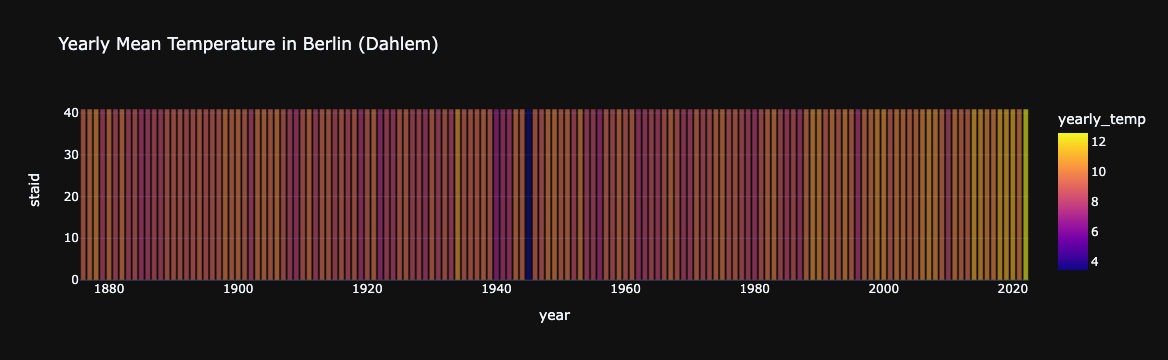

In [15]:
# plotting
fig = px.bar(df_4, 
             x='year', 
             y='staid', 
             color = 'yearly_temp', 
             # hover_name = 'year', # redundant
             barmode = 'group', 
             opacity = 0.6,
             template = 'plotly_dark',
            title = 'Yearly Mean Temperature in Berlin (Dahlem)'
            )
fig.show()
fig.write_html('warming_stripes.html')

---
## Additional Analysis

### Weather Station Locations and Count

In [21]:
# create subset for barplot
df_2_grp = df_2.drop(columns = ['year'])['alpha3'].value_counts().to_frame()
df_2_grp.head()

alpha3
NOR    1435
DEU    1080
SWE     852
RUS     524
AUT     433

In [17]:
# create subset for line
df_2_grp2 = df_2.groupby('year').count().reset_index().sort_values(by = 'year', ascending = True)
df_2_grp2.head()

year  staname  alpha3  latitude  longitude
0  1756        3       3         3          3
1  1763        1       1         1          1
2  1775        1       1         1          1
3  1781        1       1         1          1
4  1814        4       4         4          4

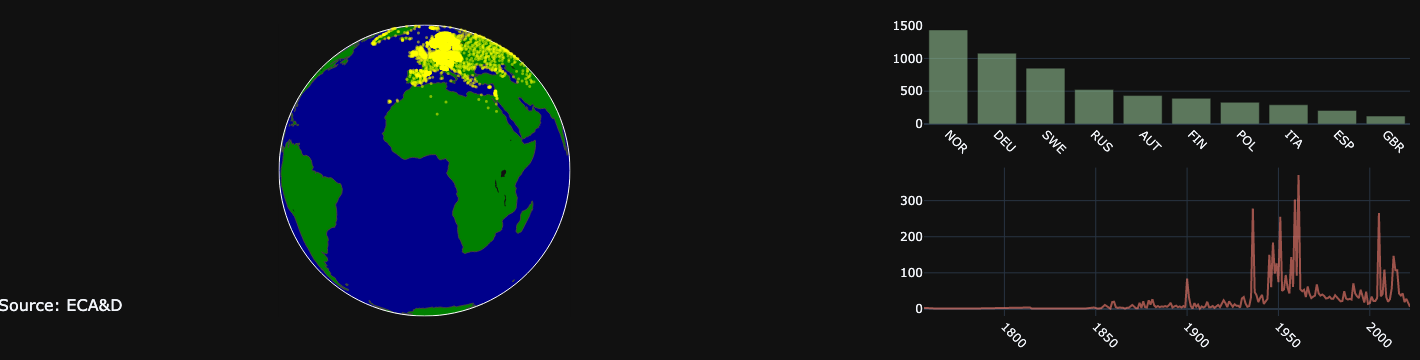

In [18]:
# source: https://plotly.com/python/mixed-subplots/

from plotly.subplots import make_subplots

# add subplot
fig = make_subplots(
    rows=2, cols=2,
    column_widths=[0.6, 0.4],
    row_heights=[0.4, 0.6],
    specs=[[{"type": "scattergeo", "rowspan": 2}, {"type": "bar", "rowspan":1}],
          [None,{"type": "scatter", "rowspan":1}]],
    column_titles=(['Weather Stations in Europe'])
                         )


# add scattergeo
fig.add_trace(
    go.Scattergeo(lat=df_2["latitude"],
                  lon=df_2["longitude"],
                  mode="markers",
                  hoverinfo="text",
                  showlegend=False,
                  marker=dict(color="yellow", size=3, opacity=0.5)),
    row=1, col=1
)


# add barplot
fig.add_trace(
    go.Bar(x=df_2_grp.index[0:10],y=df_2_grp['alpha3'][0:10], marker=dict(color="darkseagreen"), showlegend=False, opacity = 0.6),
    row=1, col=2,
)


# add scatterplot
fig.add_trace(
    go.Scatter(x=df_2_grp2['year'],y=df_2_grp2['staname'], marker=dict(color="salmon"), showlegend=False, opacity = 0.6),
    row=2, col=2,
)


# update scattergeo
fig.update_geos(
    projection_type="orthographic",
    # resolution = 50,
    scope = 'world',
    landcolor="Green",
    oceancolor="DarkBlue",
    showocean=True,
    framecolor='White'
    # projection_scale=2,
    # projection_tilt=5,
)
 

# Rotate x-axis labels
fig.update_xaxes(tickangle=45)


# Set theme, margin, and annotation in layout
fig.update_layout(
    template="plotly_dark",
    margin=dict(r=10, t=25, b=40, l=60),
    annotations=[
        dict(
            text="Source: ECA&D",
            showarrow=False,
            # xref="paper",
            # yref="paper",
            x=0,
            y=0)
    ]
)

    
fig.show()
fig.write_html("station_count.html")